A to-do list (delete later):
- Explore libraries for visualising missing data in Python 
- Deal with the missing data in both datasets 
- Sort out all of the mess below 
- Include plots that illustrate cool trends in the data
- Find strongest correlations
- Compare the datasets from both years
- Standardise prices (see 05_07 of Python Data Science course)

## Introduction

I obtained data on Airbnbs in Edinburgh for both 2019/20 (compiled on 25th June 2019) and 2020/21 (compiled on 23rd June 2020). All of the data were collected by the [Inside Airbnb](http://insideairbnb.com/get-the-data.html) project, although only the most recent year is available on their website. The 2019-20 data were sourced on [Kaggle](https://www.kaggle.com/thoroc/edinburgh-inside-airbnb). Here, I take a first look at the **listings** from the **2019/20** data.

The data has 106 fields describing 13,245 Airbnb listings.

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

listings = pd.read_csv('../data19/listings.csv')
listings.shape

(13245, 106)

## Missing Data & Duplicates

In [123]:
listings.drop_duplicates().shape

(13245, 106)

There are no duplicated records in this dataset, but there are missing data. 

In [124]:
listings.isna().any().any()

True

In [125]:
listings.loc[:, listings.isnull().any()].columns

Index(['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_s

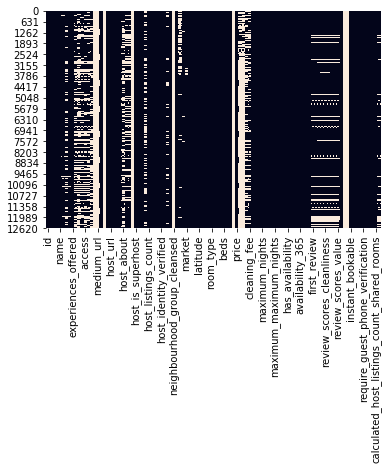

In [126]:
sn.heatmap(listings.isnull(), cbar=False)

Columns with missing data fall into the following categories:
- URLs (e.g. `host_thumbnail_url`). I am not interested in these anyway. They're likely to be missing when individuals have not uploaded pictures.
- User-entered text (e.g. `description`). These I may be interested in. They could be missing if the user has not filled them out.
- Host attributes (e.g. `host_neighbourhood`). It is less clear to me why these would be missing.
- Review attributes (e.g. `review_scores_rating`). It could be that these are missing when there are no reviews for that property. 
- Property attributes (e.g. `bathrooms`). It is unclear why these would be missing, but thankfully they never have more than 1% missing values. 

I remove any columns that I will not use in the future or that are made entirely or almost entirely of missing values. 

In [127]:
print("% missing values for columns with missing values")
for (columnName, contents) in listings.iteritems():
    missing = 100 - ((len(listings.index) - contents.isnull().sum())/len(listings.index) * 100)
    if (missing != 0):
        print(columnName, ": ", "{0:.2f}".format(missing))

% missing values for columns with missing values
name :  0.01
summary :  2.86
space :  21.93
description :  0.94
neighborhood_overview :  28.49
notes :  53.45
transit :  26.87
access :  31.61
interaction :  28.28
house_rules :  38.44
thumbnail_url :  100.00
medium_url :  100.00
xl_picture_url :  100.00
host_name :  0.14
host_since :  0.14
host_location :  0.42
host_about :  42.35
host_response_time :  25.59
host_response_rate :  25.59
host_acceptance_rate :  100.00
host_is_superhost :  0.14
host_thumbnail_url :  0.14
host_picture_url :  0.14
host_neighbourhood :  42.94
host_listings_count :  0.14
host_total_listings_count :  0.14
host_has_profile_pic :  0.14
host_identity_verified :  0.14
neighbourhood :  17.32
neighbourhood_group_cleansed :  100.00
city :  0.12
state :  19.25
zipcode :  1.61
market :  1.55
bathrooms :  0.09
bedrooms :  0.03
beds :  0.11
square_feet :  99.81
weekly_price :  91.12
monthly_price :  94.05
security_deposit :  35.81
cleaning_fee :  28.24
first_review :  15.

In [128]:
listings = listings.drop(['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_thumbnail_url',
              'host_picture_url', 'city', 'state', 'license', 'jurisdiction_names',
              'experiences_offered', 'access', 'interaction', 'has_availability', 'market', 
              'neighbourhood_group_cleansed', 'host_acceptance_rate', 'zipcode', 'square_feet',
              'weekly_price', 'monthly_price', 'name', 'host_total_listings_count', 'country_code'],
              axis = 1)

The missingness I am most concerned about is for `neighbourhood`. I am very interested in this column, but it has substantial missingness (17.32%), and as a categorical variable with many levels would not be easy to impute. I am forced to take a complete cases approach to `neighbourhood`. 

In [129]:
have_neighbourhood = np.invert(listings.neighbourhood.isnull().to_numpy())
listings = listings[have_neighbourhood]

I choose to median impute values for columns that I deem essential (mostly property columns). These columns have less than 1% missing values, and thus I feel little need to perform a computationally intensive imputation process. My median imputation is designed to avoid potential bias introduced by a complete cases approach. Columns treated with median imputation were `host_listings_count`, `bathrooms`, `bedrooms` and `beds`. As it turns out, the medians for these columns are 1, 1, 2, and 1, respectively.

In [130]:
for column in ['host_listings_count', 'bathrooms', 'beds', 'bedrooms']:
    listings.loc[(listings[column].isnull()), column] = listings[column].median()

I am unsure how much I will use host attributes and reviews, so I do not take any action on these missing values at this stage. However, note that there are clearly clusters of missingness. Records missing a single review value are likely to be missing them all, and records missing a single host response attribute are likely to be missing more than just this one host response attribute.

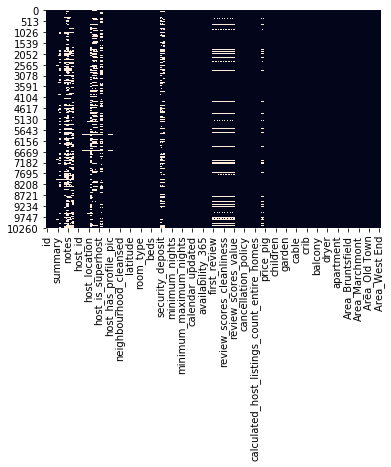

In [176]:
sn.heatmap(listings.isnull(), cbar=False)

## Exploring Pricing

First I transform the price columns into numeric values.

In [131]:
from pandas.api.types import is_numeric_dtype

def format_price(dataframe, column):
    if not is_numeric_dtype(dataframe[column]):
        dataframe[column] = dataframe[column].str.replace('$', '')
        dataframe[column] = dataframe[column].str.replace(',', '')
        dataframe[column] = pd.to_numeric(dataframe[column])

format_price(listings, "price")
format_price(listings, "extra_people")

Airbnbs can opt to charge extra for additional people staying in larger properties. The `price` column only refers to `guests_included`, and additional guests are charged at `extra_people`. Therefore, I can create another column which is price per included guest (`price_pig` = `price`/`guests_included`). I can also create a column that is price at full capacity (`price_fullcap` = `price` + `extra_people` * (`accomodates` - `guests_included`)). On 6 occassions this results in a negative number for `price_fullcap`, because the owner of the Airbnb has listed the price as including more individuals than the property can accomodate. In such cases, `price_fullcap` is just set to `price`.

In [132]:
listings = listings.assign(price_pig = lambda dataframe : dataframe['price']/dataframe['guests_included'])

listings = listings.assign(price_fullcap = lambda dataframe : dataframe['price'] + dataframe['extra_people'] * (dataframe['accommodates'] - dataframe['guests_included']))

listings.query('price_pig > price_fullcap')[['price_pig', 'price_fullcap', 'accommodates', 'price', 'extra_people', 'guests_included']]

listings['price_fullcap'] = np.where((listings.price_pig > listings.price_fullcap),listings.price,listings.price_fullcap)

### Distributions and Outlier Detection 

The histogram of price per included guest shows an extreme right skew. Price here refers to the **mean** price per included guests per night over a 365 day period. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F85C20CC88>]],
      dtype=object)

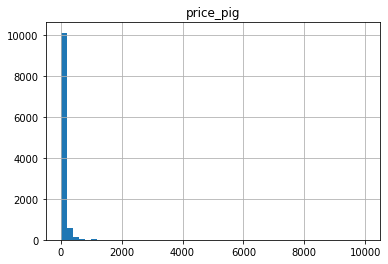

In [133]:
listings.hist(column = 'price_pig', bins = 50)

There are values of a dataset where the price per included guest is 0. The maximum price per included guest per night is £9,999. A really special feature of this dataset is that it includes the links to the Airbnb's pages. This means that, so long as the listing is still active, I can literally check to see if there is a reason that a value is extreme. I choose to use my own knowledge of hotel prices to create sensible upper and lower bounds for the data. Personally, I have found statistical methods (e.g. 3 standard deviations) often hide real features of the data. I use the price per included guest to make these judgements, because a property may appear to be an outlier just because it sleeps a large number of individuals. 

In [134]:
print(listings['price_pig'].min())
print(listings['price_pig'].max())

0.0
9999.0


Any Airbnb less than £8 per person a night would be a potential outlier, as this seems unreasonably cheap. There are 18 Airbnbs under £8 a night, and two of these are listed as costing nothing at all. I visually inspect these properties in the data for any feature that might explain this (e.g. they all have the same host, or are a special property type...). Airbnbs under £8 per person tend include many more people in the base rate than the mean for all Airbnbs in this dataset (mean ± standard deviation: 7.83 ± 4.93 vs 1.77 ± 1.50). It makes sense that Airbnbs that include more people would be cheaper per person because the 'bare minimum' costs to the host are split between all of the people. These are the same trends that I observed in the 2020-21 data (but not these datasets are not independent - many of the Airbnbs are present in both datasets!).

In [135]:
listings[listings.price_pig < 8][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
655,7.000000,1,https://www.airbnb.com/rooms/3032366,14630118,6,84,3.0,Apartment,15.0
900,2.600000,3,https://www.airbnb.com/rooms/3769281,3713949,15,21,1.0,Apartment,0.0
1064,6.250000,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
3762,2.916667,1,https://www.airbnb.com/rooms/13937408,82866543,12,314,1.0,Apartment,10.0
5373,2.272727,1,https://www.airbnb.com/rooms/18609453,101731795,11,125,1.0,Townhouse,0.0
5851,5.000000,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
6343,4.062500,3,https://www.airbnb.com/rooms/19903475,140937670,16,92,1.0,Apartment,0.0
6948,0.000000,2,https://www.airbnb.com/rooms/20752585,2689840,1,0,1.0,Apartment,0.0
6998,7.500000,2,https://www.airbnb.com/rooms/20925062,105274239,6,0,3.0,Apartment,0.0
8953,6.125000,1,https://www.airbnb.com/rooms/25915418,194554364,16,131,4.0,Apartment,0.0


In fact, if I filter the results to only include Airbnbs with less than 5 guests (I choose this number because it is two deviations away from the mean for the whole sample), then I am only left with 6 results. Two of these are most likely errors as they are £0. I choose to exclude these 6 results.

In [136]:
listings[(listings.price_pig < 8) & (listings.guests_included < 5)][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
1064,6.25,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
5851,5.00,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
6948,0.00,2,https://www.airbnb.com/rooms/20752585,2689840,1,0,1.0,Apartment,0.0
9735,5.00,2,https://www.airbnb.com/rooms/27163272,119509555,2,289,2.0,Apartment,20.0


In [137]:
listings = listings[(listings.price > 8) | (listings.guests_included >= 5)]

A luxury apartment might charge £1000 a night per person if it was also centrally located. Moreover, recall that price here is derived from the mean price, so Airbnbs that are exclusively available on the night of some special event (e.g. the Edinburgh Hogmanay festival) may seem inflated compared to others. Thirty-six Airbnbs exceed £1000 per night per person. Some hosts are very common in this subset. I could find no justification for these high values outside of error or an unusual quirk of availability (which unfortunately, I cannot correct for with the data I have), so I decided to exclude these data points.

In [138]:
listings[listings.price_pig > 1000][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
378,2600.00,2,https://www.airbnb.com/rooms/1367733,646220,2,0,1.0,Apartment,0.0
913,6747.00,1,https://www.airbnb.com/rooms/3797987,19504588,1,335,5.0,Apartment,18.0
994,1134.50,2,https://www.airbnb.com/rooms/4167650,20923270,2,15,3.0,Apartment,10.0
995,1133.00,2,https://www.airbnb.com/rooms/4167874,20923270,2,26,2.0,Apartment,10.0
2987,1500.00,1,https://www.airbnb.com/rooms/12385633,21782787,1,0,1.0,Apartment,0.0
3636,5000.00,1,https://www.airbnb.com/rooms/13745807,80447250,1,89,4.0,Apartment,0.0
3640,3000.00,1,https://www.airbnb.com/rooms/13756769,80447250,1,89,3.0,Apartment,0.0
3641,7000.00,1,https://www.airbnb.com/rooms/13756895,80447250,1,89,5.0,Apartment,0.0
3642,7000.00,1,https://www.airbnb.com/rooms/13756984,80447250,1,89,6.0,Apartment,0.0
4018,2354.00,1,https://www.airbnb.com/rooms/14225887,86457709,1,0,1.0,Apartment,0.0


In [139]:
listings = listings[(listings.price < 1000)]

The skew in price per included guest is still very extreme. However, I am unwilling to blindly remove any more data points at this stage without further justification for their removal. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F866939248>]],
      dtype=object)

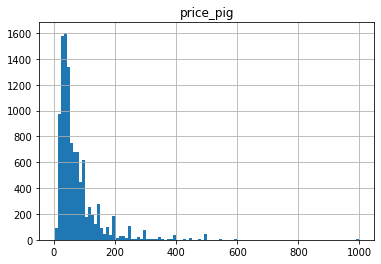

In [140]:
listings.hist(column = 'price_pig', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F850CB1CC8>]],
      dtype=object)

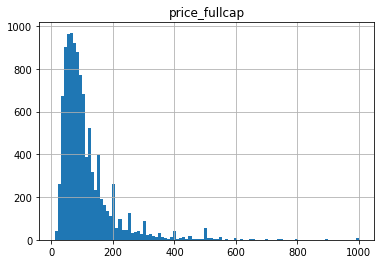

In [141]:
listings.hist(column = 'price_fullcap', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F850CB4908>]],
      dtype=object)

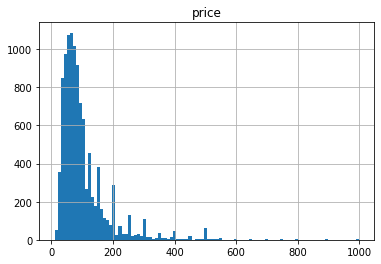

In [142]:
listings.hist(column = 'price', bins = 100)

## Exploring Ameneties

Below, I add a column that indicates whether an Airbnb has a real bed or not. I also pull a number of different amenities out of the ameneites column.

In [143]:
listings.amenities.head()

0    {TV,Internet,Wifi,"Wheelchair accessible",Kitc...
1    {TV,Wifi,Kitchen,"Paid parking off premises",E...
3    {TV,"Cable TV",Internet,Wifi,Kitchen,"Pets liv...
4    {TV,Wifi,Kitchen,"Paid parking off premises",H...
5    {TV,"Cable TV",Wifi,Kitchen,"Paid parking off ...
Name: amenities, dtype: object

In [144]:
listings['real_bed'] = listings['bed_type'].apply(lambda x: 1 if (x == 'Real Bed') else 0)

def countAmenities(search_term, col_name):
    listings[col_name] = listings['amenities'].apply(lambda x: 1 if search_term in x else 0)
    return(listings)

amenitiesDict = {
    "pets": "Pets allowed",
    "children": "Family/kid friendly",
    "aircon": "Air conditioning",
    "wifi": "Wifi",
    "washer": "Washer",
    "garden": "Garden or backyard",
    "oven": "Oven",
    "gym": "Gym",
    "tv": "TV",
    "cable": "Cable TV",
    "free_parking": "Free parking on premises",
    "breakfast": "Breakfast",
    "dishwasher": "Dishwasher",
    "crib": "Crib",
    "workspace": "Laptop friendly workspace",
    "lift": "Elevator",
    "wheelchair_access": "Wheelchair accessible",
    "balcony": "Patio or balcony",
    "bathtub": "Bathtub",
    "lugagge_dropoff": "Luggage dropoff allowed",
    "self_checkin": "Self check-in",
    "dryer": "Dryer",
    "waterfront": "Waterfront",
    "fireplace": "Indoor fireplace"
}


for key in amenitiesDict:
    listings = countAmenities(amenitiesDict[key], key)

None of the amenities features are strongly correlated with price: their correlations are all less than 0.1, with the exception of a tumble dryer. Other features positively correlated with price are lifts and TVs. Perhaps surprisingly, features negatively correlated with price are breakfast, ovens, and self check-ins.

In [145]:
corrMatrix = listings[["price", "price_pig", "price_fullcap"] + list(amenitiesDict.keys())].corr()
corrMatrix["price_pig"].sort_values()

oven                -0.074077
self_checkin        -0.072472
workspace           -0.056991
garden              -0.046065
breakfast           -0.045336
wifi                -0.036736
lugagge_dropoff     -0.029168
balcony             -0.021635
waterfront          -0.020465
bathtub             -0.020116
free_parking        -0.012975
dishwasher          -0.009096
wheelchair_access   -0.005440
pets                 0.001202
gym                  0.001420
cable                0.007460
children             0.013943
lift                 0.033132
aircon               0.038131
crib                 0.039763
washer               0.059062
fireplace            0.067993
tv                   0.099869
dryer                0.125054
price_fullcap        0.734384
price                0.802754
price_pig            1.000000
Name: price_pig, dtype: float64

The columns `space`, `description`, `neighborhood_overview`, `summary` and `notes` offer large prose added by the owners of the Airbnb. At this moment in time, I choose to stick with the ameneties I have extracted, although these could be a source of further data.

I collapse together housing types and one hot encode them. Surprisingly, the only correlation greater than 0.1 is for hostels: for all price types, hostels correlate positively with price! I find this surprising given hostels reputations as cheap places to stay. However, this could be influenced by the fact that hostels are more likely to be in central areas; hostels advertised as Airbnbs are not typical hostels; or that hostels are uncommon in the dataset thus susceptible to the influences of outliers. 

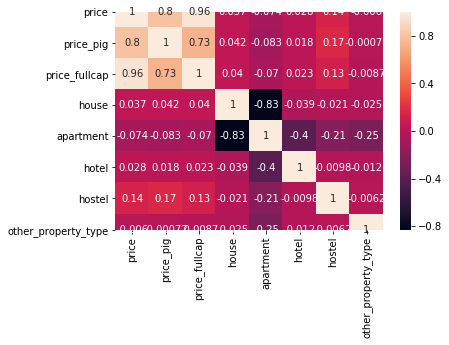

,price,price_pig,price_fullcap,house,apartment,hotel,hostel,other_property_type
price,1.000000,0.802754,0.962600,0.036975,-0.074121,0.028470,0.137424,-0.006047
price_pig,0.802754,1.000000,0.734384,0.041995,-0.082965,0.018263,0.169908,-0.000716
price_fullcap,0.962600,0.734384,1.000000,0.039561,-0.070468,0.023172,0.125156,-0.008689
house,0.036975,0.041995,0.039561,1.000000,-0.828649,-0.039221,-0.020533,-0.024792
apartment,-0.074121,-0.082965,-0.070468,-0.828649,1.000000,-0.395810,-0.207213,-0.250200
hotel,0.028470,0.018263,0.023172,-0.039221,-0.395810,1.000000,-0.009808,-0.011842
hostel,0.137424,0.169908,0.125156,-0.020533,-0.207213,-0.009808,1.000000,-0.006200
other_property_type,-0.006047,-0.000716,-0.008689,-0.024792,-0.250200,-0.011842,-0.006200,1.000000


In [146]:
listings['house'] = listings['property_type'].apply(lambda x: 1 if x in ['House', 'Cottage', 'Townhouse', 'Bungalow', 'Tiny house'] else 0)
listings['apartment'] = listings['property_type'].apply(lambda x: 1 if x in ['Apartment', 'Serviced apartment', 'Condominium', 'Aparthotel'] else 0)
listings['hotel'] = listings['property_type'].apply(lambda x: 1 if x in ['Boutique hotel', 'Guest suite', 'Guesthouse', 'Hotel', 'Bed and breakfast'] else 0)
listings['hostel'] = listings['property_type'].apply(lambda x: 1 if x in ['Hostel'] else 0)
listings['other_property_type'] = listings['property_type'].apply(lambda x: 1 if x in ['Loft', 'Villa', 'Camper/RV', 'Other', 'Tent', 'Cabin', 'Campsite', 'Chalet', 'Hut', 'Casa particular (Cuba)', 'Farm stay', 'Barn', 'Boat'] else 0)

corrMatrix = listings[['price', 'price_pig', 'price_fullcap', 'house', 'apartment', 'hotel', 'hostel', 'other_property_type']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

## Exploring Neighbourhoods

### One Hot Encoding

I one hot encode the neighbourhoods.

In [147]:
areas = pd.get_dummies(listings.neighbourhood, prefix='Area')
areas['id'] = listings['id']
listings = listings.merge(areas, on = 'id')
listings.head()

,id,listing_url,scrape_id,last_scraped,summary,space,description,neighborhood_overview,notes,transit,...,Area_Leith,Area_Marchmont,Area_Morningside,Area_New Town,Area_Newington,Area_Old Town,Area_Southside,Area_Stockbridge,Area_Tollcross,Area_West End
0,15420,https://www.airbnb.com/rooms/15420,20190625184115,2019-06-25,"Stunning, impeccably refurbished spacious grou...",This is a huge and luxurious apartment for 2 -...,"Stunning, impeccably refurbished spacious grou...","The neighbourhood is in the historic New Town,...",Please note that because of my interest in int...,It is easy to walk to many of the main tourist...,...,0,0,0,1,0,0,0,0,0,0
1,24288,https://www.airbnb.com/rooms/24288,20190625184115,2019-06-25,Boho rustic-chic former warehouse Loft located...,"Two bedroom, very central Loft apartment with ...",Boho rustic-chic former warehouse Loft located...,It's all in the mix: Culture-museums and galle...,The apartment is in the City centre so being a...,Walk to key central attractions or catch a bus...,...,0,0,0,0,0,0,1,0,0,0
2,44552,https://www.airbnb.com/rooms/44552,20190625184115,2019-06-25,Pleasant double room in 2 bedroom ground floor...,You will be staying in a pleasant double room ...,Pleasant double room in 2 bedroom ground floor...,NaN,NaN,There are frequent buses to the centre and oth...,...,1,0,0,0,0,0,0,0,0,0
3,47616,https://www.airbnb.com/rooms/47616,20190625184115,2019-06-25,Annemarie & I would like to welcome you to our...,The flat has two floors with bedrooms and bath...,Annemarie & I would like to welcome you to our...,We're at the quiet end of a residential street...,"As we are both working office-hours, arrivals ...",There are 30 bus routes within 5 minutes' walk...,...,0,0,0,0,0,0,1,0,0,0
4,48645,https://www.airbnb.com/rooms/48645,20190625184115,2019-06-25,Large comfortable private room in the heart of...,Your room is large with a very comfortable hig...,Large comfortable private room in the heart of...,The Canongate is an area rich in culture and h...,Edinburgh city center now has free unlimited w...,The apartment is 400 metres from the Airport B...,...,0,0,0,0,0,1,0,0,0,0


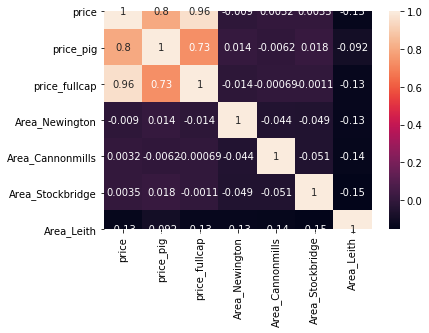

,price,price_pig,price_fullcap,Area_Newington,Area_Cannonmills,Area_Stockbridge,Area_Leith
price,1.000000,0.802754,0.962600,-0.009006,0.003222,0.003540,-0.134913
price_pig,0.802754,1.000000,0.734384,0.013870,-0.006238,0.017933,-0.092454
price_fullcap,0.962600,0.734384,1.000000,-0.013560,-0.000691,-0.001105,-0.131590
Area_Newington,-0.009006,0.013870,-0.013560,1.000000,-0.044072,-0.048932,-0.130190
Area_Cannonmills,0.003222,-0.006238,-0.000691,-0.044072,1.000000,-0.051467,-0.136936
Area_Stockbridge,0.003540,0.017933,-0.001105,-0.048932,-0.051467,1.000000,-0.152036
Area_Leith,-0.134913,-0.092454,-0.131590,-0.130190,-0.136936,-0.152036,1.000000


In [148]:
corrMatrix = listings[['price', 'price_pig', 'price_fullcap', 'Area_Newington', 'Area_Cannonmills', 'Area_Stockbridge', 'Area_Leith']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

## Exploring Ratings and Host Characteristics

### Distributions and Outlier Detection

Review ratings are split into six variables which are scored out of 10: value for money, accuracy of description, cleanliness, communication, location and check-in. There is also an overall rating which is scored out of 100. All of these tend to cluster towards high scores.

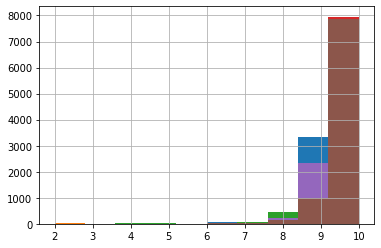

In [173]:
for rating in ['review_scores_value', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_checkin']:
    listings[rating].hist()

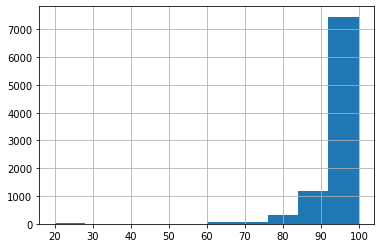

In [175]:
listings['review_scores_rating'].hist()

Host attributes that may correlate with pricing may be how long an individual has been a host for, their response time and rate, their location, how many Airbnbs they own, and their verification status. The same host can be represented multiple times in this dataset. Altogether, there are 7,544 unique hosts.

In [235]:
len(listings.host_id.unique())

7544

The number of Airbnbs they own is described as a simple integer in `host_listings_count`. The host's location is contained within both `host_neighbourhood` and `host_location`. The hosts neighbourhoods can be outside of Edinburgh, so are not particularly useful as there are many, many of them. I can use the `host_location` column to see whether or not a host has reported that they live in Edinburgh.

In [231]:
host_in_edin = [1 if area == "Edinburgh, Scotland, United Kingdom" else 0 for area in listings.host_location]
listings['host_in_edin'] = host_in_edin

Airbnb hosts are allowed to take bookings without having their identity verified with photo ID such as a driving licence or a passport. Such individuals have an f in the `host_identity_verified` column. Only around 37% of hosts in this dataset are verified.

Airbnb superhosts are hosts who meet a certain standard set by Airbnb: which includes high response rates, low cancellations, and high ratings. A key benefit of booking with a superhost is that they cannot cancel your booking. In this dataset, a host either is a superhost (t) or is not (f) as indicated by the `host_is_superhost` column. Around 32% of hosts in this dataset are superhosts. I recode these boolean columns into 1s and 0s. 

In [221]:
def get_percent_true(col, df):
    return sum(df[col] == 't')/len(df.index) * 100

print("% hosts that are verified: ", get_percent_true('host_identity_verified', listings))
print("% hosts that are superhosts: ", get_percent_true('host_is_superhost', listings))

def code_as_nums(series):
    return [1 if i == 't' else 0 for i in series]

listings.host_is_superhost = code_as_nums(listings.host_is_superhost)
listings.host_identity_verified = code_as_nums(listings.host_identity_verified)

% hosts that are verified:  0.0
% hosts that are superhosts:  31.884461781369


`host_response_time` is a categorical variable with four levels: within an hour, within a few hours, within a day, and a few days or more. `host_response_rate` is a percentage that describes the percentage of individuals who enquired that the host has responded to. Most hosts in the dataset have a high response rate.

0        1
1        1
2        1
3        0
4        1
        ..
10762    0
10763    0
10764    0
10765    0
10766    0
Name: host_is_superhost, Length: 10767, dtype: int64

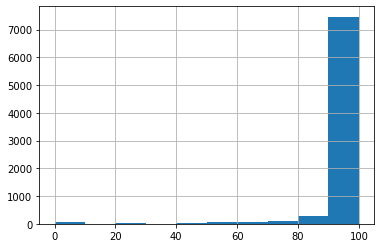

In [223]:
listings['host_response_rate'] = listings['host_response_rate'].str.replace('%', '')
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'])
listings.host_response_rate.hist()

### Correlations

There are some anticipated correlations: Airbnbs in favourable areas are likely to be more expensive, whereas those that rate high on value for money are likely to be cheaper. 

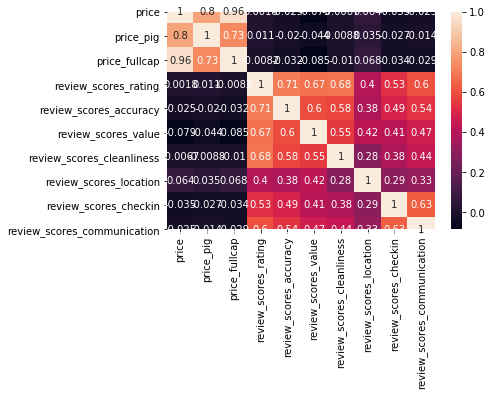

,price,price_pig,price_fullcap,review_scores_rating,review_scores_accuracy,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_checkin,review_scores_communication
price,1.000000,0.802754,0.962600,0.001802,-0.025308,-0.079412,-0.006743,0.063824,-0.034537,-0.024964
price_pig,0.802754,1.000000,0.734384,0.011359,-0.019731,-0.044475,-0.008759,0.035280,-0.027186,-0.013953
price_fullcap,0.962600,0.734384,1.000000,-0.008190,-0.031700,-0.085110,-0.009956,0.067528,-0.034129,-0.028890
review_scores_rating,0.001802,0.011359,-0.008190,1.000000,0.705114,0.674557,0.683883,0.400349,0.525613,0.603037
review_scores_accuracy,-0.025308,-0.019731,-0.031700,0.705114,1.000000,0.597029,0.576354,0.379057,0.488913,0.537747
review_scores_value,-0.079412,-0.044475,-0.085110,0.674557,0.597029,1.000000,0.554664,0.422014,0.411574,0.466409
review_scores_cleanliness,-0.006743,-0.008759,-0.009956,0.683883,0.576354,0.554664,1.000000,0.284584,0.381066,0.438672
review_scores_location,0.063824,0.035280,0.067528,0.400349,0.379057,0.422014,0.284584,1.000000,0.294800,0.325261
review_scores_checkin,-0.034537,-0.027186,-0.034129,0.525613,0.488913,0.411574,0.381066,0.294800,1.000000,0.634733
review_scores_communication,-0.024964,-0.013953,-0.028890,0.603037,0.537747,0.466409,0.438672,0.325261,0.634733,1.000000


In [164]:
corrMatrix = listings[['price', 'price_pig', 'price_fullcap', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_value', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_checkin', 'review_scores_communication']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

In [178]:
for column in listings.columns:
    print(column)

id
listing_url
scrape_id
last_scraped
summary
space
description
neighborhood_overview
notes
transit
house_rules
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_is_superhost
host_neighbourhood
host_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
first_review
last_review
review_scores_rating
review_scores_accuracy
review_score

## Comparison of 2019-20 and 2020-21

Of the 10,767 properties in the cleaned 2019-21 dataset, 8,151 of these are also present in the 2020-21 dataset.

In [179]:
listings20 = pd.read_csv('../data20/listings.csv')

listings20.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15420,https://www.airbnb.com/rooms/15420,20200623173438,2020-06-24,Georgian Boutique Apt City Centre,"Stunning, impeccably refurbished spacious grou...",This is a huge and luxurious apartment for 2 -...,"Stunning, impeccably refurbished spacious grou...",none,"The neighbourhood is in the historic New Town,...",...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,2.86
1,24288,https://www.airbnb.com/rooms/24288,20200623173438,2020-06-24,"Cool central Loft, sleeps 4, 2 double bed+en-s...",Boho rustic-chic former warehouse Loft located...,"Two bedroom, very central Loft apartment with ...",Boho rustic-chic former warehouse Loft located...,none,It's all in the mix: Culture-museums and galle...,...,t,f,flexible,f,f,1,1,0,0,1.83
2,38628,https://www.airbnb.com/rooms/38628,20200623173438,2020-06-24,Edinburgh Holiday Let,Brunstane - Daiches Braes (close to Portobello...,Check out (Website hidden by Airbnb) Free Wi-...,Brunstane - Daiches Braes (close to Portobello...,none,Quiet and easy access to outside.,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,0.75
3,44552,https://www.airbnb.com/rooms/44552,20200623173438,2020-06-24,Double room - spacious Leith flat,Pleasant double room in 2 bedroom ground floor...,You will be staying in a pleasant double room ...,Pleasant double room in 2 bedroom ground floor...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,1.66
4,47616,https://www.airbnb.com/rooms/47616,20200623173438,2020-06-24,"City flat, close to nature and the Fringe",Annemarie & I would like to welcome you to our...,The flat has two floors with bedrooms and bath...,Annemarie & I would like to welcome you to our...,none,We're at the quiet end of a residential street...,...,f,f,moderate,f,f,1,0,1,0,0.70


In [182]:
pd.merge(listings, listings20, on = 'id', how = 'inner').shape

(8151, 234)

In [33]:
corr_matrix = listings20.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

sol

host_listings_count             host_total_listings_count                      1.000000e+00
maximum_maximum_nights          maximum_nights_avg_ntm                         9.955196e-01
minimum_maximum_nights          maximum_nights_avg_ntm                         9.950020e-01
calculated_host_listings_count  calculated_host_listings_count_entire_homes    9.935348e-01
minimum_minimum_nights          minimum_nights_avg_ntm                         9.929071e-01
                                                                                   ...     
scrape_id                       Area_Stockbridge                               1.547409e-16
                                review_scores_accuracy                         1.135993e-16
                                maximum_maximum_nights                         6.150043e-17
                                minimum_nights                                 3.684382e-17
                                Area_Southside                                 3

In [ ]:
Look for associations between area and house type, amenities, etc 

## Prepare Datasets for Modelling

Acceptance rate is empty. Response time is a categorical variable, response rate is a % (% of individuals responded to).

In [102]:
listings.city.value_counts()

Edinburgh                           12958
Edinburgh                              90
Edimburgo                              20
Queensferry                            15
Currie                                 14
                                    ...  
Cramond Village, near Edinburgh         1
Edinburgh, Scotland, EH6 5PU            1
Kirkliston, Edinburgh                   1
Leith                                   1
Stockbridge, New Town, Edinburgh        1
Name: city, Length: 63, dtype: int64

So few do not have profile pictures it's probably not useful. Lisence is also not useful. Host location may be informative.

In [107]:
#listings.host_location.value_counts()
#listings.host_has_profile_pic.value_counts()
listings.review_scores_value.value_counts()

10.0    6481
9.0     3862
8.0      529
7.0       79
6.0       77
2.0       11
4.0       10
5.0        8
Name: review_scores_value, dtype: int64

In [248]:
listings.calculated_host_listings_count_entire_homes.value_counts()

1      5849
0      4127
2      1115
3       441
4       215
5       161
7       151
135     135
6       103
90       90
9        84
14       84
39       78
65       74
12       73
27       54
15       45
10       42
41       41
11       33
29       29
23       29
28       28
25       25
8        24
19       22
22       22
20       21
21       21
16       16
13       13
Name: calculated_host_listings_count_entire_homes, dtype: int64

In [10]:
listings.interaction

0        Guests will be sent full details of what is su...
1        Will meet guests on arrival and at check-out i...
2        On arrival - I live upstairs and can help gues...
3        I am normally around to help with any question...
4                                                      NaN
                               ...                        
13240    Meet and Greet / Key exchange and tour.Contact...
13241                                                  NaN
13242                                                  NaN
13243                                                  NaN
13244                                                  NaN
Name: interaction, Length: 13245, dtype: object